In [1]:
!pip install transformers
%pip install numpy
%pip install tensorflow


In [2]:
!pip install scikit-learn
%pip install pandas

In [3]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer, BertConfig, TFBertModel
from sklearn.model_selection import train_test_split
import pickle
import random
import sys
import math
from scipy import stats
from scipy.spatial import distance
import random
import os

In [4]:
BASE_FOLDER = "data/"
#INPUT_FILE = "hate_norm_combined.pkl"
OUTPUT_FOLDER = "hate_intensity_linear_weights_att/"
OUTPUT_FILE = "hate_int_linear_trans42_ATT"
BERT_MODEL = "distilbert-base-uncased"
MAX_LENGTH = 128
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 50
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 2 #(Default 10)
BATCH_SIZE = 32


def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

In [5]:
import tensorflow as tf

class ExponentialPositionalEncoding_inc(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=512):
        super(ExponentialPositionalEncoding_inc, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

    def build(self, input_shape):
        position = tf.range(0, self.max_len, dtype=tf.float32)
        # Use an exponential term that increases towards the end of the sentence
        div_term = tf.exp(0.01 * position)
        encoding = position * div_term
        encoding = tf.reshape(encoding, (1, self.max_len, 1))
        self.encoding = tf.tile(encoding, [1, 1, self.d_model])

    def call(self, x):
        return x + self.encoding[:, :tf.shape(x)[1], :]



In [6]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(
        input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


## Define base bert configs
config = BertConfig(dropout=BERT_DROPOUT,
                    attention_dropout=BERT_DROPOUT,
                    output_attentions=True)
config.output_hidden_states = False
transformer_model = TFBertModel.from_pretrained(BERT_MODEL, config=config)
for layer in transformer_model.layers[:3]:  ## We are freezing first 3 layers
    layer.trainable = False

# Defining tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL,
                                                do_lower_case=True,
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH,
                                                pad_to_max_length=True)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.4.ffn.lin1.bias', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.q_lin.weight', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.3.ffn.lin1.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.weight'

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
class CustomBERTModel(tf.keras.Model):
    def __init__(self, max_len=MAX_LENGTH, d_model=768):
        super(CustomBERTModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(BERT_MODEL)
        for layer in self.bert.layers[:3]:
            layer.trainable = False
        self.positional_encoding = ExponentialPositionalEncoding_inc(d_model=d_model, max_len=max_len)
        self.bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT))
        self.global_max_pool = tf.keras.layers.GlobalMaxPool1D()
        self.dense = tf.keras.layers.Dense(DENSE_UNITS, activation='relu')
        self.dropout = tf.keras.layers.Dropout(DENSE_DROPOUT)
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        embedding_layer = self.bert(input_ids, attention_mask=attention_mask)[0]
        encoded_embedding = self.positional_encoding(embedding_layer)
        x = self.bi_lstm(encoded_embedding)
        x = self.global_max_pool(x)
        x = self.dense(x)
        x = self.dropout(x)
        return self.output_layer(x)

# Tokenization and model definition would remain the same
# ...

# Define the input layers
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

# Instantiate and compile the custom BERT model
custom_bert_model = CustomBERTModel()



You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.4.ffn.lin1.bias', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.q_lin.weight', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.3.ffn.lin1.weight', 'distilbert.tr

In [8]:
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=custom_bert_model([input_ids_in, input_masks_in]))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 custom_bert_model (CustomB  (None, 1)                    1098149   ['input_token[0][0]',         
 ERTModel)                                                41         'masked_token[0][0]']        
                                                                                                  
Total params: 109814941 (418.91 MB)
Trainable params: 332701 (1.27 MB)
Non-trainable params: 1

In [ ]:
import pandas as pd
input_data = pd.read_csv("hate_norm_with_span.csv")

In [ ]:


intensity_value = []
hate_sentences = []

for i in range(len(input_data)):
    intensity_value.append(int(input_data['Original_Intensity'][i]))
    hate_sentences.append(input_data['Sentence'][i])
    intensity_value.append(int(input_data['Normalized_Intensity'][i]))
    hate_sentences.append(input_data['Normalized_Sentence'][i])

c = list(zip(intensity_value, hate_sentences))
random.shuffle(c)
intensity_value, hate_sentences = zip(*c)

X_tr, X_te, y_tr, y_te = train_test_split(hate_sentences,
                                          intensity_value,
                                          test_size=TEST_SIZE,
                                          random_state=1)

train_input_ids, train_input_masks, train_input_segment = tokenize(
    X_tr, tokenizer)
test_input_ids, test_input_masks, test_input_segment = tokenize(
    X_te, tokenizer)
y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)

  0%|          | 0/4843 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1211/1211 [00:00<00:00, 1632.47it/s]


In [ ]:
model.fit(x=[train_input_ids, train_input_masks],
          y=y_tr,
          epochs=5,
          validation_split=0.1,
          batch_size=BATCH_SIZE)

print("TEST split", TEST_SIZE)
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)
print(results)
result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float)
result = result.flatten()
print("pear", stats.pearsonr(result, y_te))
print("cosine", 1 - distance.cosine(result, y_te))

Epoch 1/5
137/137 [==============================] - 248s 2s/step - loss: 5.8982 - acc: 0.0067 - root_mean_squared_error: 2.4286 - val_loss: 4.3025 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0742
Epoch 2/5
137/137 [==============================] - 217s 2s/step - loss: 4.9130 - acc: 0.0067 - root_mean_squared_error: 2.2165 - val_loss: 4.2216 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0546
Epoch 3/5
137/137 [==============================] - 208s 2s/step - loss: 4.8658 - acc: 0.0067 - root_mean_squared_error: 2.2058 - val_loss: 4.2108 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0520
Epoch 4/5
137/137 [==============================] - 227s 2s/step - loss: 4.8429 - acc: 0.0067 - root_mean_squared_error: 2.2007 - val_loss: 4.2657 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0654
Epoch 5/5
137/137 [==============================] - 215s 2s/step - loss: 4.7319 - acc: 0.0067 - root_mean_squared_error: 2.1753 - val_loss: 4.1150 - val_acc: 0.0062 - val_root_mean_sq

<ipython-input-9-586d0141856e>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.array(result, dtype=np.float)


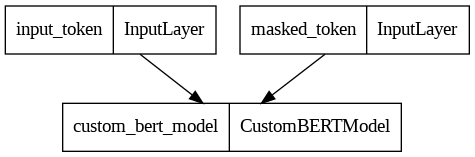

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model_rcnn.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [9]:
import pandas as pd
train_df = pd.read_csv("hate_train.csv")
val_df = pd.read_csv("hate_val.csv")
test_df = pd.read_csv("hate_test.csv")

In [10]:
X_train_temp = train_df['Sentence']
y_train_temp = train_df['Intensity']
X_val = val_df['Sentence']
y_val = val_df['Intensity']
X_te = test_df['Sentence']
y_te = test_df['Intensity']


In [11]:
# Tokenize and convert train, validation, and test sets
train_input_ids, train_input_masks, train_input_segment = tokenize(X_train_temp, tokenizer)
val_input_ids, val_input_masks, val_input_segment = tokenize(X_val, tokenizer)
test_input_ids, test_input_mask, test_input_segment = tokenize(X_te, tokenizer)

# Convert labels to numpy arrays
y_tr = np.asarray(y_train_temp)
y_val = np.asarray(y_val)
y_te = np.asarray(y_te)

  0%|          | 0/4540 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 909/909 [00:01<00:00, 691.80it/s]


In [12]:
# Train model on train set and validate on validation set
model.fit(
    x=[train_input_ids, train_input_masks],
    y=y_tr,
    epochs=5,
    validation_data=([val_input_ids, val_input_masks], y_val),
    batch_size=BATCH_SIZE
)


Epoch 1/5
142/142 [==============================] - 254s 1s/step - loss: 5.9383 - acc: 0.0068 - root_mean_squared_error: 2.4369 - val_loss: 4.4647 - val_acc: 0.0033 - val_root_mean_squared_error: 2.1130
Epoch 2/5
142/142 [==============================] - 196s 1s/step - loss: 4.9462 - acc: 0.0068 - root_mean_squared_error: 2.2240 - val_loss: 4.2735 - val_acc: 0.0033 - val_root_mean_squared_error: 2.0672
Epoch 3/5
142/142 [==============================] - 194s 1s/step - loss: 4.7234 - acc: 0.0068 - root_mean_squared_error: 2.1733 - val_loss: 4.1955 - val_acc: 0.0033 - val_root_mean_squared_error: 2.0483
Epoch 4/5
142/142 [==============================] - 193s 1s/step - loss: 4.7105 - acc: 0.0068 - root_mean_squared_error: 2.1704 - val_loss: 4.1999 - val_acc: 0.0033 - val_root_mean_squared_error: 2.0494
Epoch 5/5
142/142 [==============================] - 211s 1s/step - loss: 4.7626 - acc: 0.0068 - root_mean_squared_error: 2.1823 - val_loss: 4.0596 - val_acc: 0.0033 - val_root_mean_sq

In [13]:
# Evaluate model on the test set
print("Test set evaluation:")
test_results = model.evaluate(x=[test_input_ids, test_input_mask], y=y_te)
val_results = model.evaluate(x=[val_input_ids, val_input_masks], y=y_val)
print(test_results)





Test set evaluation:
19/19 [==============================] - 6s 338ms/step - loss: 4.0596 - acc: 0.0033 - root_mean_squared_error: 2.0148
[4.078675270080566, 0.0066006602719426155, 2.0195729732513428]


In [14]:
# Make predictions on the test set
test_predictions = model.predict(x=[test_input_ids, test_input_mask])
test_predictions = np.array(test_predictions, dtype=np.float).flatten()

# Make predictions on the test set
val_predictions = model.predict(x=[val_input_ids, val_input_masks])
val_predictions = np.array(val_predictions, dtype=np.float).flatten()

29/29 [==============================] - 14s 338ms/step


<ipython-input-14-b7343f6258ba>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_predictions = np.array(test_predictions, dtype=np.float).flatten()


19/19 [==============================] - 7s 363ms/step


<ipython-input-14-b7343f6258ba>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_predictions = np.array(val_predictions, dtype=np.float).flatten()


In [15]:
from sklearn import metrics
from scipy.spatial import distance
# Calculate Pearson correlation and cosine similarity
pearson_corr = stats.pearsonr(test_predictions, y_te)[0]
cosine_sim = 1 - distance.cosine(test_predictions, y_te)
print(f"Pearson Correlation: {pearson_corr}")
print(f"Cosine Similarity: {cosine_sim}")

Pearson Correlation: 0.3453403651998436
Cosine Similarity: 0.9405767394971526


In [16]:
import pandas as pd

# Convert predictions and labels into pandas DataFrames
#train_df = pd.DataFrame({'Prediction': train_predictions, 'Label': y_tr})
val_df = pd.DataFrame({'Prediction': val_predictions, 'Label': y_val})
test_df = pd.DataFrame({'Prediction': test_predictions, 'Label': y_te})

# Save DataFrames as CSV files
#train_df.to_csv('train_predictions.csv', index=False)
val_df.to_csv('val_predictions_custombert_exp.csv', index=False)
test_df.to_csv('test_predictions_custombert_exp.csv', index=False)
